In [1]:
# Predicting Student Dropout Risk Using Machine Learning (Final Organized Version)

# ==========================================================
# 1. Import Necessary Libraries
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')



Data loading and preprocessing

In [2]:

# ==========================================================
# 2. Load Dataset
# ==========================================================
data = pd.read_csv('data.csv')

# ==========================================================
# 3. Data Cleaning: Drop 'Enrolled' Students
# ==========================================================
print("Original Target Distribution:")
print(data['Target'].value_counts())
data = data[data['Target'].isin(['Dropout', 'Graduate'])]

# ==========================================================
# 4. Encode Target Variable
# ==========================================================
label_mapping = {'Dropout': 0, 'Graduate': 1}
data['Target'] = data['Target'].map(label_mapping)

# ==========================================================
# 5. Basic Info and Missing Values
# ==========================================================
print("\nData Shape:", data.shape)
print("\nData Info:")
print(data.info())

missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]
if missing_values.empty:
    print("\nNo Missing Values Found.")
else:
    print("\nMissing Values per Column:")
    print(missing_values)


Original Target Distribution:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Data Shape: (3630, 37)

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3630 non-null   int64  
 1   Application mode                                3630 non-null   int64  
 2   Application order                               3630 non-null   int64  
 3   Course                                          3630 non-null   int64  
 4   Daytime/evening attendance                      3630 non-null   int64  
 5   Previous qualification                          3630 non-null   int64  
 6   Previous qualification (grade)                  3630 non-null   float64
 7   Nacionality                                     36

Exploratory Data Analysis 

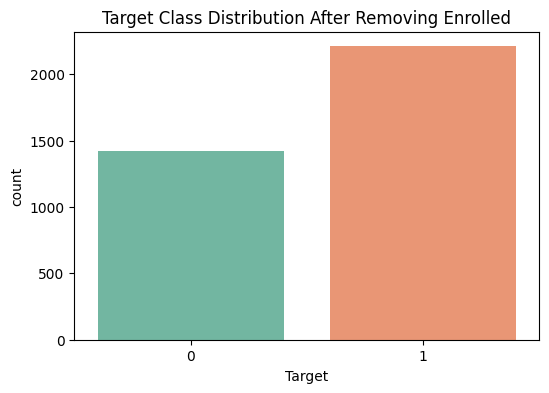

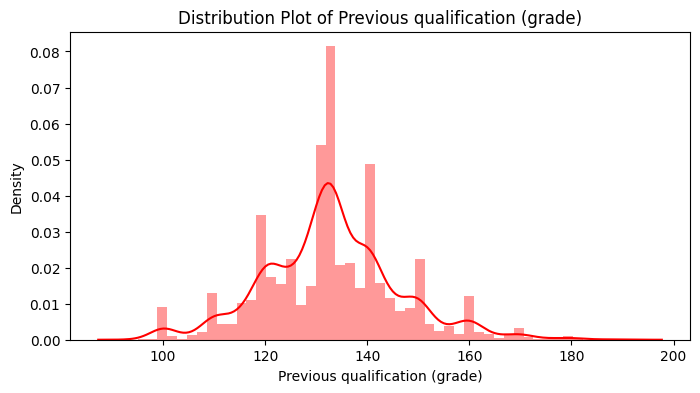

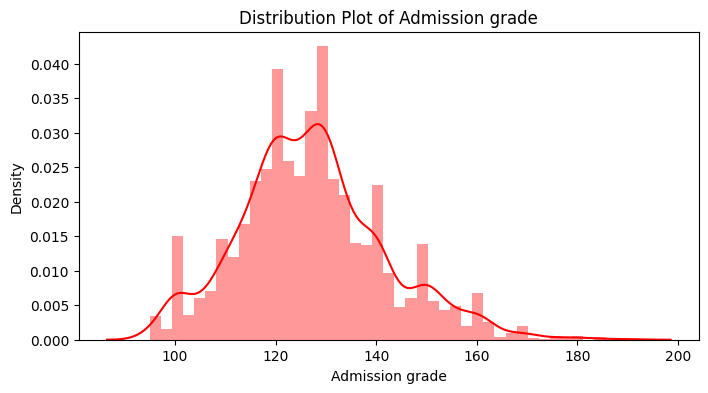

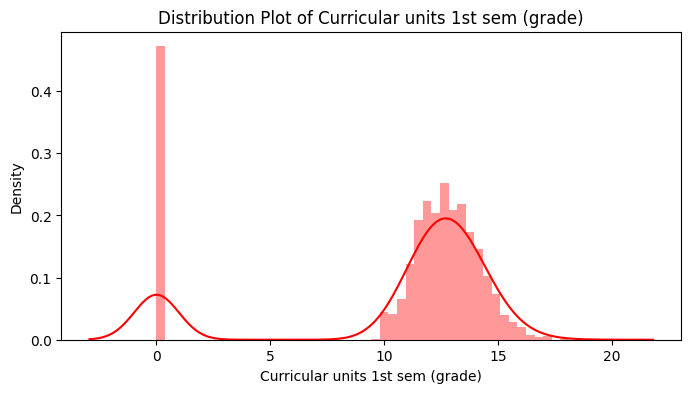

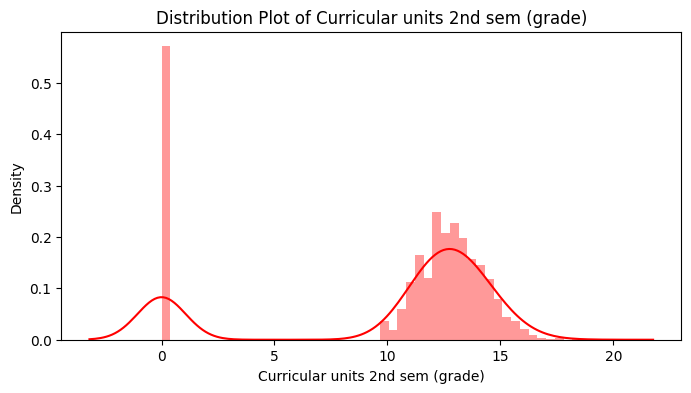

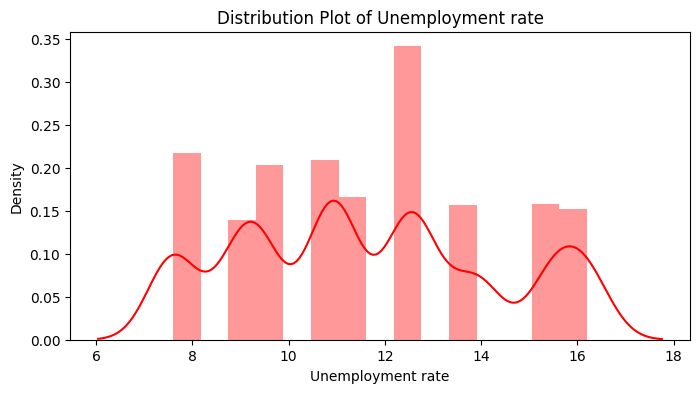

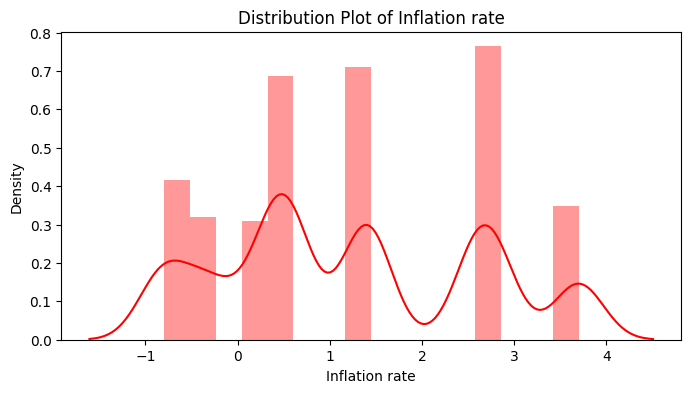

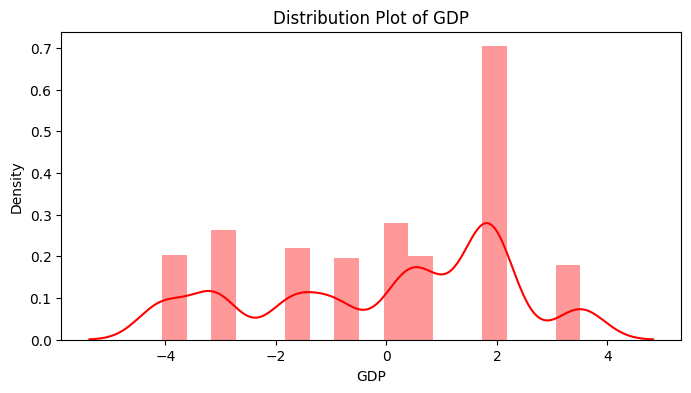

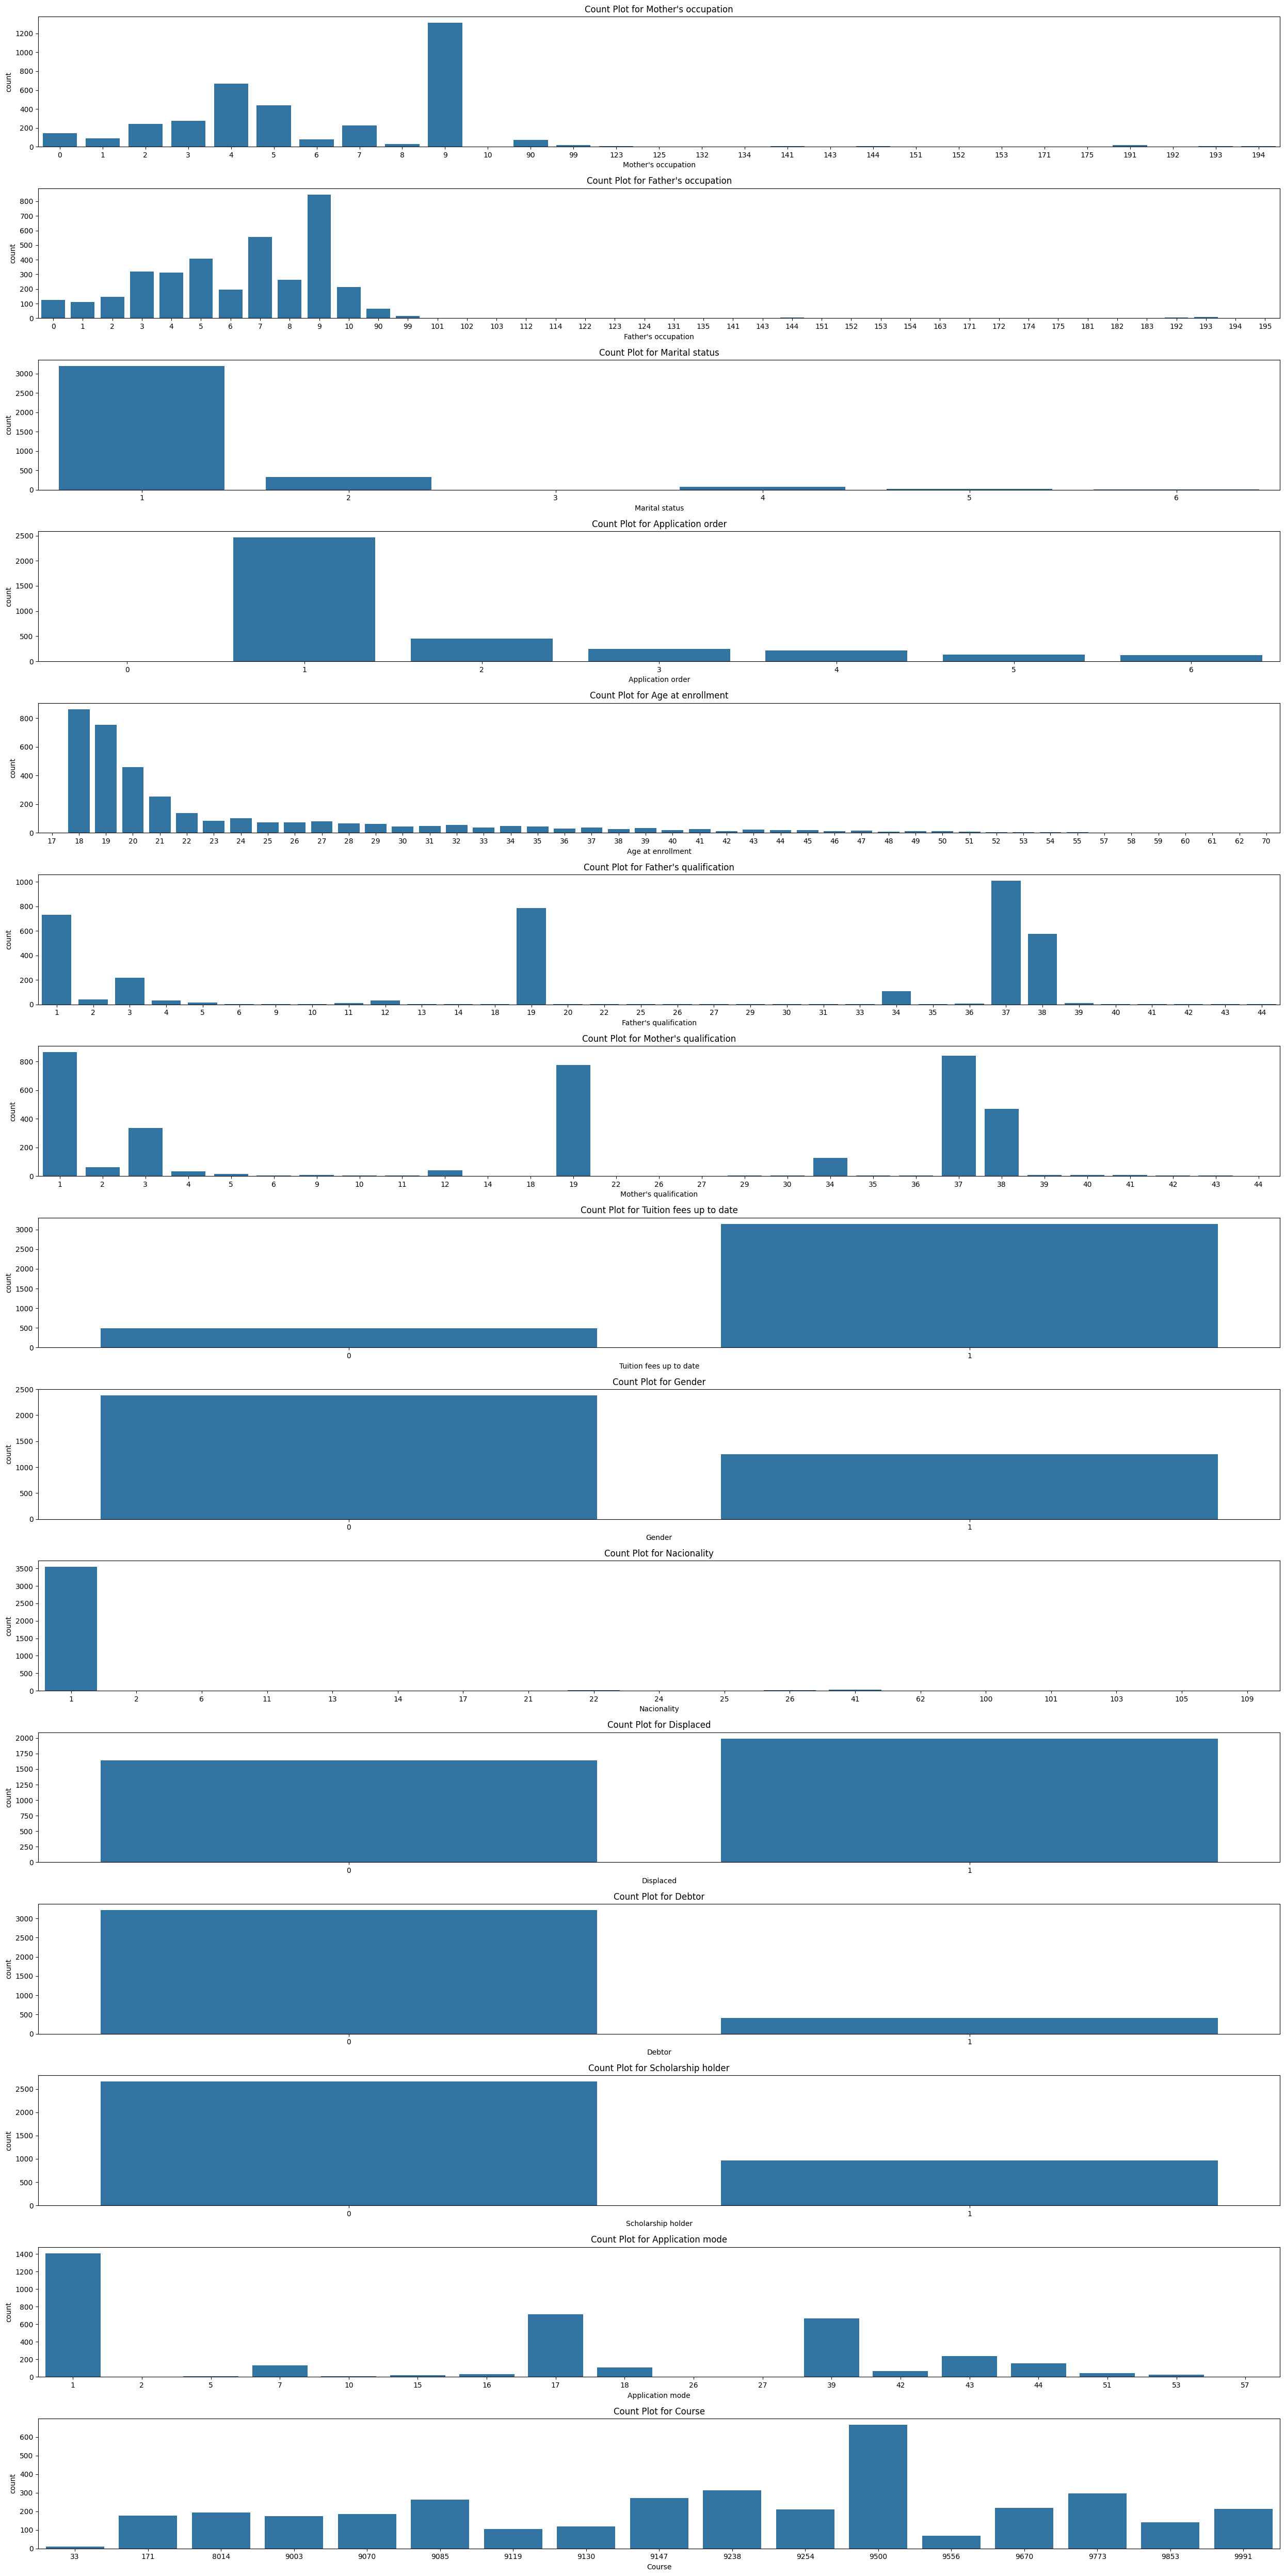

In [3]:

# ==========================================================
# 6. Exploratory Data Analysis (EDA)
# ==========================================================

# 6.1 Target Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=data, palette='Set2')
plt.title('Target Class Distribution After Removing Enrolled')
plt.show()

# 6.2 Distribution Plots for Numerical Features
data_num = data.select_dtypes(include=['float64'])
for i in data_num.columns:
    plt.figure(figsize=(8,4))
    sns.distplot(data[i], color='red')
    plt.title(f'Distribution Plot of {i}')
    plt.show()

# 6.3 Count Plots for Categorical Features
cols_ = ["Mother's occupation", "Father's occupation", 'Marital status', 'Application order',
         'Age at enrollment', "Father's qualification", "Mother's qualification",
         'Tuition fees up to date', 'Gender', 'Nacionality', 'Displaced', 'Debtor',
         'Scholarship holder', 'Application mode', 'Course']

fig, ax = plt.subplots(nrows=len(cols_), ncols=1, figsize=(25, 50))
for ind, col in enumerate(cols_):
    sns.countplot(x=col, data=data, ax=ax[ind])
    ax[ind].set_title(f'Count Plot for {col}')
plt.tight_layout()
plt.show()

In [ ]:
Feature Selection

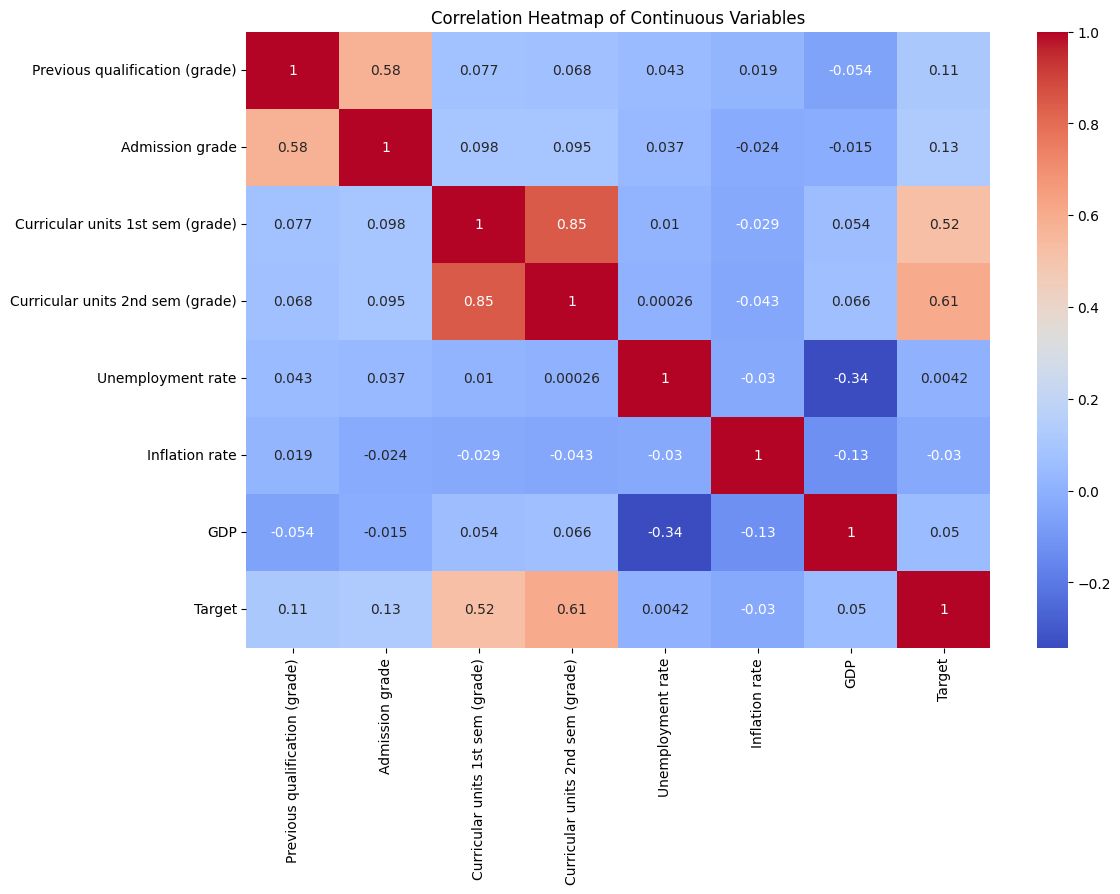


Exact Correlation Values with Target:
Target                              1.000000
Curricular units 2nd sem (grade)    0.605350
Curricular units 1st sem (grade)    0.519927
Admission grade                     0.128058
Previous qualification (grade)      0.109464
GDP                                 0.050260
Unemployment rate                   0.004198
Inflation rate                     -0.030326
Name: Target, dtype: float64

Preliminary Feature Importance (Random Forest Guidance):
Curricular units 2nd sem (approved)               0.252601
Curricular units 2nd sem (grade)                  0.208451
Curricular units 1st sem (approved)               0.161892
Curricular units 1st sem (grade)                  0.089037
Tuition fees up to date                           0.082112
Age at enrollment                                 0.045407
Scholarship holder                                0.030083
Curricular units 2nd sem (evaluations)            0.025511
Curricular units 1st sem (evaluations)    

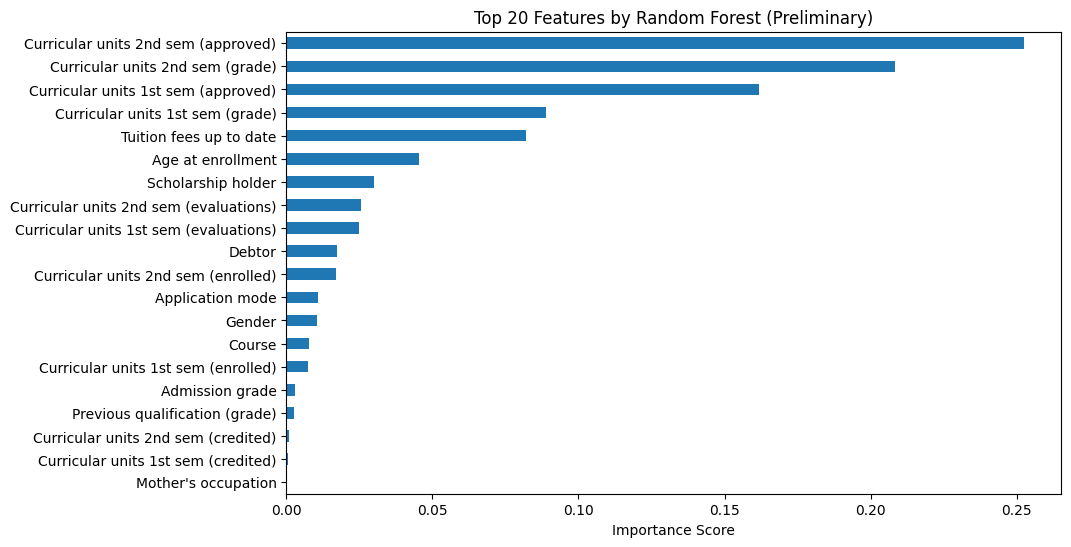

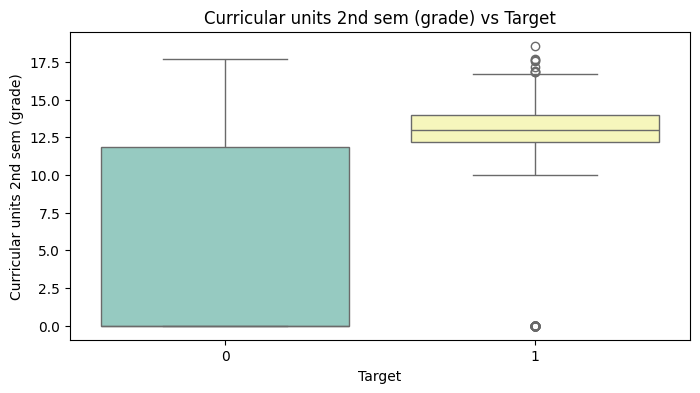

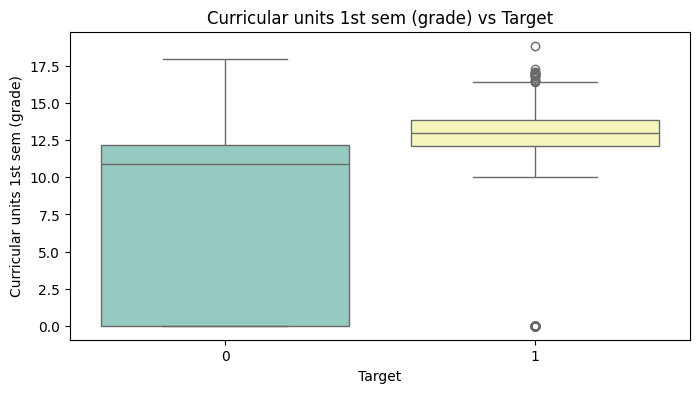

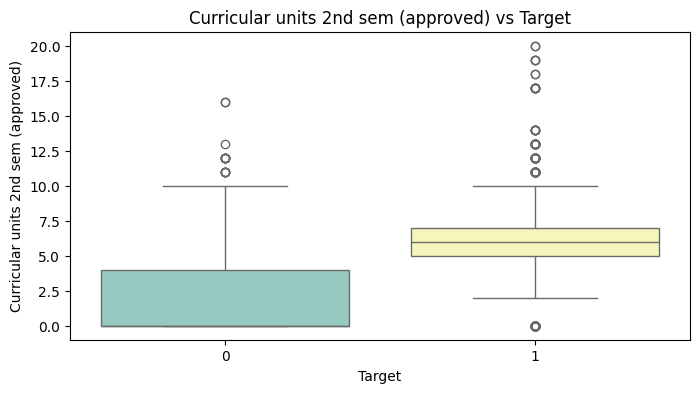

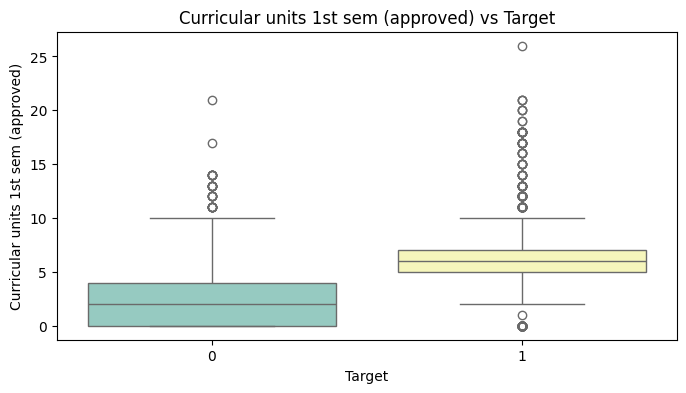

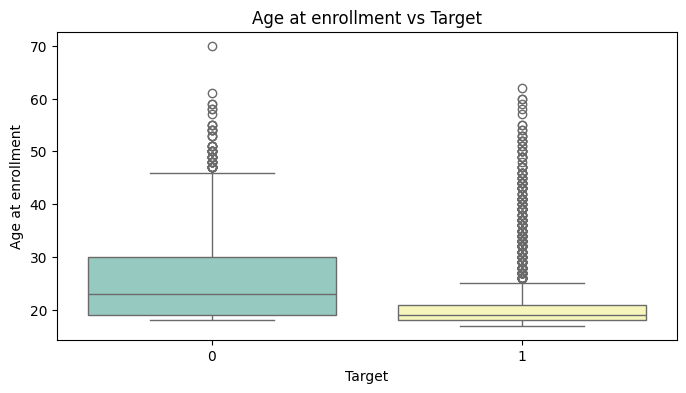

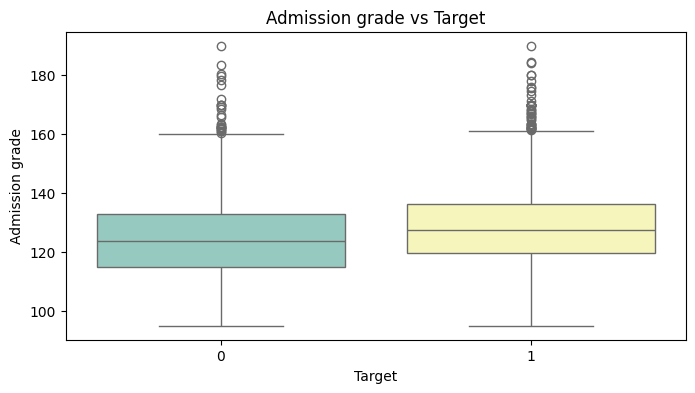

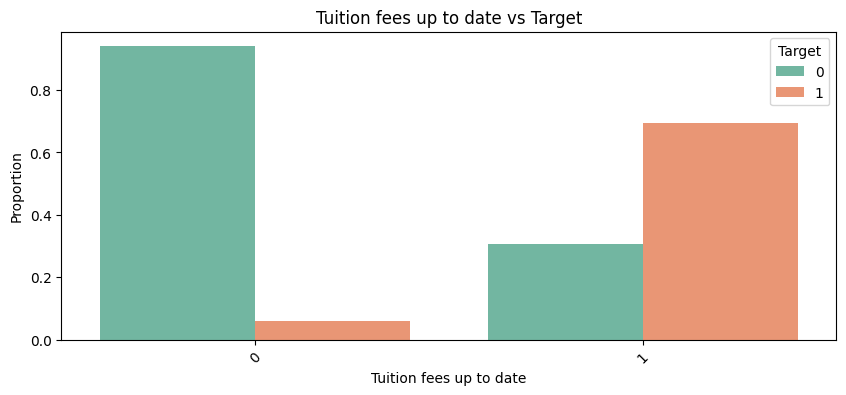

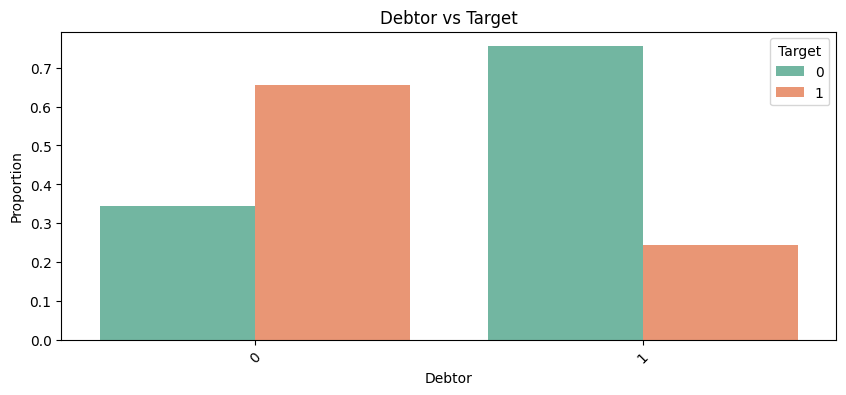

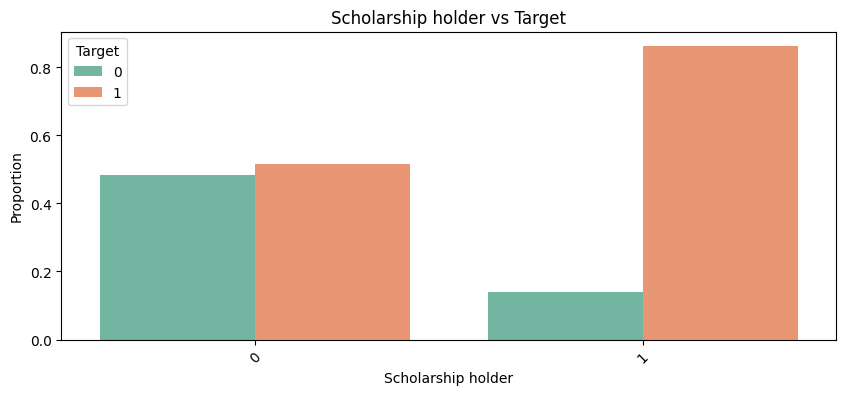

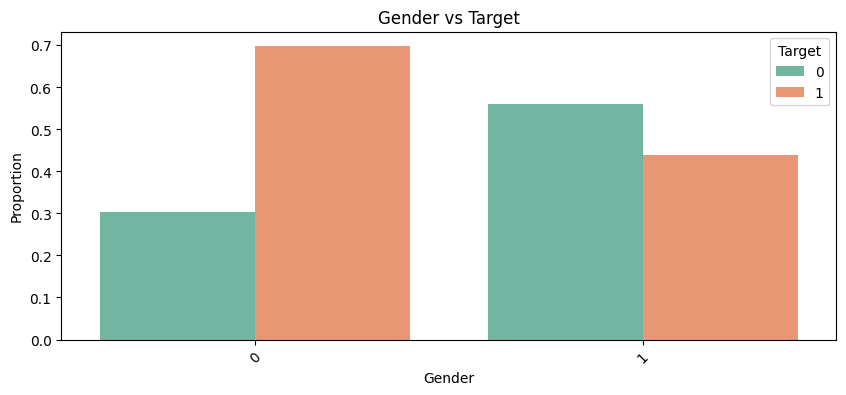

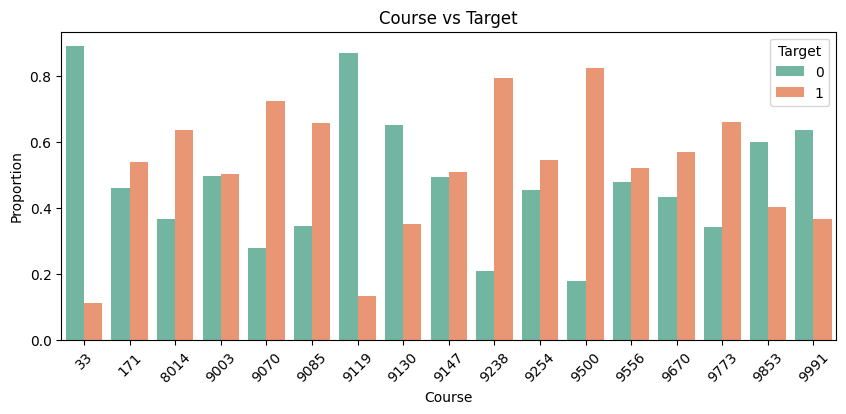

In [4]:


# ==========================================================
# 7. Feature Selection
# ==========================================================

# 7.1 Correlation Heatmap (Continuous Variables)
continuous_features_with_target = data.select_dtypes(include=['float64']).copy()
continuous_features_with_target['Target'] = data['Target'].astype(float)
correlation = continuous_features_with_target.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Continuous Variables')
plt.show()

print("\nExact Correlation Values with Target:")
print(correlation['Target'].sort_values(ascending=False))

# 7.2 Feature Importance Using Random Forest
print("\nPreliminary Feature Importance (Random Forest Guidance):")
rf_temp = RandomForestClassifier(max_depth=3, random_state=42)
rf_temp.fit(data.drop('Target', axis=1), data['Target'])
feat_importances = pd.Series(rf_temp.feature_importances_, index=data.drop('Target', axis=1).columns)
feat_importances = feat_importances.sort_values(ascending=False)
print(feat_importances)

plt.figure(figsize=(10,6))
feat_importances.head(20).plot(kind='barh')
plt.title('Top 20 Features by Random Forest (Preliminary)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()

# 7.3 Feature vs Target Boxplots (Numerical) and Proportions (Categorical)
numerical_features = [
    'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
    'Age at enrollment', 'Admission grade']

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Target', y=feature, data=data, palette='Set3')
    plt.title(f'{feature} vs Target')
    plt.show()

categorical_features = ['Tuition fees up to date', 'Debtor', 'Scholarship holder', 'Gender', 'Course']

for feature in categorical_features:
    prop_df = data.groupby([feature, 'Target']).size().reset_index(name='count')
    total = prop_df.groupby(feature)['count'].transform('sum')
    prop_df['percentage'] = prop_df['count'] / total

    plt.figure(figsize=(10, 4))
    sns.barplot(x=feature, y='percentage', hue='Target', data=prop_df, palette='Set2')
    plt.title(f'{feature} vs Target')
    plt.xticks(rotation=45)
    plt.ylabel('Proportion')
    plt.show()


In [ ]:
Preperaation fpr modeling

In [6]:

# ==========================================================
# 8. Features Selection based on correlation and feature importance and Train-Test Split
# ==========================================================

selected_features = [
    'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (approved)', 'Curricular units 1st sem (approved)',
    'Tuition fees up to date', 'Debtor', 'Scholarship holder',
    'Age at enrollment', 'Admission grade', 'Marital status', 'Gender', 'Course']

X = data[selected_features]
y = data['Target']

print("Class distribution before train-test split:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nClass distribution in training set:")
print(y_train.value_counts())

print("\nClass distribution in test set:")
print(y_test.value_counts())

Class distribution before train-test split:
Target
1    2209
0    1421
Name: count, dtype: int64

Class distribution in training set:
Target
1    1767
0    1137
Name: count, dtype: int64

Class distribution in test set:
Target
1    442
0    284
Name: count, dtype: int64


Modeling

In [21]:
# Step 9. Initial Model Building
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Cross-Validation (Before Tuning)
results = {}

for name, model in models.items():
    cv_scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    results[name] = {
        'Accuracy': np.mean(cv_scores['test_accuracy']),
        'Precision': np.mean(cv_scores['test_precision']),
        'Recall': np.mean(cv_scores['test_recall']),
        'F1-Score': np.mean(cv_scores['test_f1']),
        'ROC-AUC': np.mean(cv_scores['test_roc_auc'])
    }


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1413, number of negative: 910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 2323, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608265 -> initscore=0.440026
[LightGBM] [Info] Start training from score 0.440026
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1413, number of negative: 910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

In [22]:

# Step 10. Hyperparameter Tuning (Only for Best Models: Random Forest, Gradient Boosting, LightGBM)
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
}

tuned_models = {}

for name, params in param_grids.items():
    grid = GridSearchCV(models[name], param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    tuned_name = f"{name} (Tuned)"
    tuned_models[tuned_name] = best_model

    cv_scores = cross_validate(best_model, X_train, y_train, cv=cv, scoring=scoring)
    results[tuned_name] = {
        'Accuracy': np.mean(cv_scores['test_accuracy']),
        'Precision': np.mean(cv_scores['test_precision']),
        'Recall': np.mean(cv_scores['test_recall']),
        'F1-Score': np.mean(cv_scores['test_f1']),
        'ROC-AUC': np.mean(cv_scores['test_roc_auc'])
    }


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1767, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 2904, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608471 -> initscore=0.440890
[LightGBM] [Info] Start training from score 0.440890
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1413, number of negative: 910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

In [23]:
# Step 11.Build and Evaluate Stacking Classifier
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('rf', tuned_models['Random Forest (Tuned)']),
        ('gb', tuned_models['Gradient Boosting (Tuned)']),
        ('lgb', tuned_models['LightGBM (Tuned)'])
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

cv_scores = cross_validate(stacking_model, X_train, y_train, cv=cv, scoring=scoring)
results['Stacking Classifier'] = {
    'Accuracy': np.mean(cv_scores['test_accuracy']),
    'Precision': np.mean(cv_scores['test_precision']),
    'Recall': np.mean(cv_scores['test_recall']),
    'F1-Score': np.mean(cv_scores['test_f1']),
    'ROC-AUC': np.mean(cv_scores['test_roc_auc'])
}



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1413, number of negative: 910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 2323, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608265 -> initscore=0.440026
[LightGBM] [Info] Start training from score 0.440026
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1130, number of negative: 728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number o

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1767, number of negative: 1137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 2904, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608471 -> initscore=0.440890
[LightGBM] [Info] Start training from score 0.440890
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1767, number of negative: 1137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 2904, number of used features:

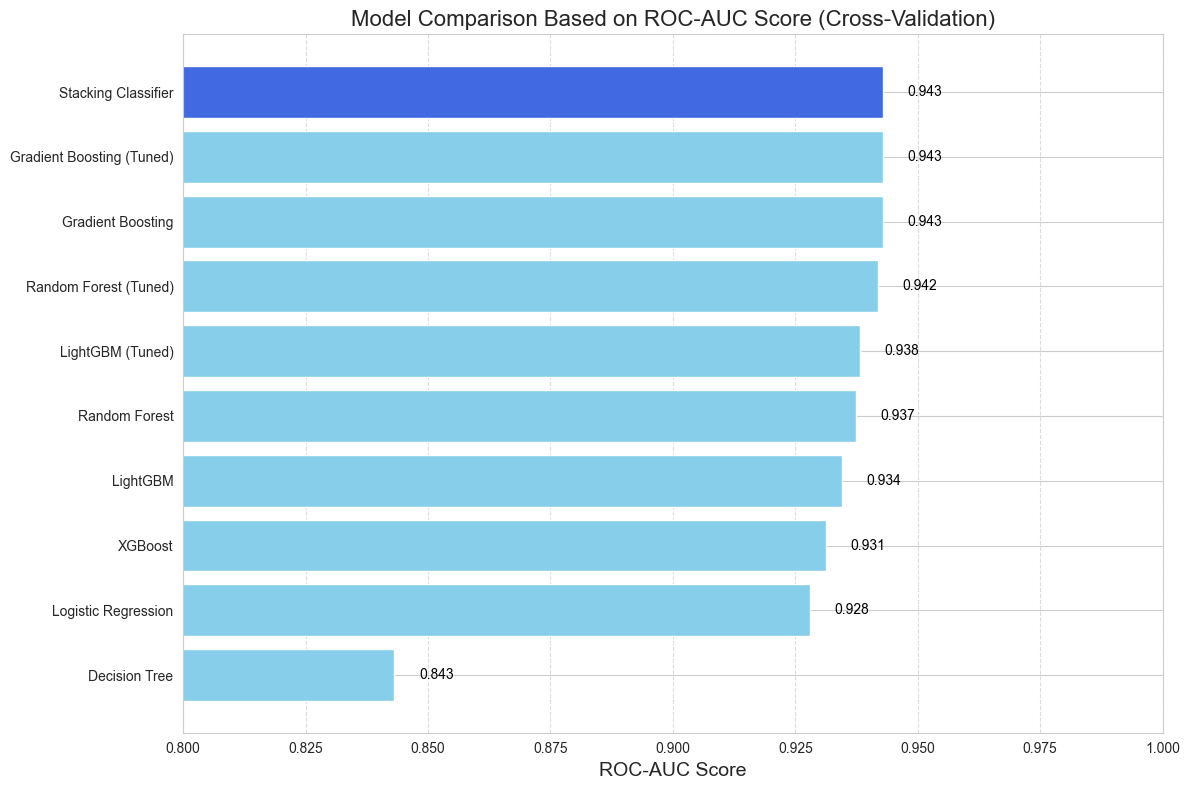

In [24]:

# Step 12.Train vs Cross-Validation Comparison (Only for Final Models)
train_val_results = {}

final_models = {**models, **tuned_models, 'Stacking Classifier': stacking_model}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]

    train_val_results[name] = {
        'Train Accuracy': accuracy_score(y_train, y_pred_train),
        'CV Accuracy': results[name]['Accuracy'],
        'Train ROC-AUC': roc_auc_score(y_train, y_proba_train),
        'CV ROC-AUC': results[name]['ROC-AUC']
    }

train_val_df = pd.DataFrame(train_val_results).T
print("\nTrain vs Cross-Validation Comparison (Final Models Only):")
print(train_val_df)

 #Final Results Table
results_df = pd.DataFrame(results).T
print("\nModel Comparison (Cross-Validation Results):")
print(results_df)

#Plot comparison 

# Sort by ROC-AUC for better display
results_df_sorted = results_df.sort_values('ROC-AUC', ascending=True)

# Set style
sns.set_style('whitegrid')

# Create color palette (highlight the top model)
colors = ['skyblue' if model != 'Stacking Classifier' else 'royalblue' for model in results_df_sorted.index]

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(results_df_sorted.index, results_df_sorted['ROC-AUC'], color=colors)

# Annotate the scores on the bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.005,  # move slightly to the right of the bar
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.3f}',
        va='center',
        fontsize=10,
        color='black'
    )

# Titles and Labels
plt.title('Model Comparison Based on ROC-AUC Score (Cross-Validation)', fontsize=16)
plt.xlabel('ROC-AUC Score', fontsize=14)
plt.xlim(0.8, 1.0)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
